## Predicting movies netflix users will want to watch

In [13]:
import pandas as pd
import numpy as np
import math
import re
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Reader, Dataset, SVD, SVDpp, Baseline 
from surprise.model_selection import  cross_validate, split
sns.set_style("ticks")

We first loaded the dataset. The kaggle dataset contained 4 huge datasets, but we decided to work only with one since it would take a lot of time.

In [14]:
# We first load the data from one of the CSVs 
df = pd.read_csv('combined_data_1.txt', header = None, names = ['Id_Cust', 'Rating'], usecols = [0,1])

df['Rating'] = df['Rating'].astype(float)

print('Dataset rows and columns: ' + str(df.shape))
print('We print the first 11 observations to have an idea of how the dataset looks like:')
print(df.iloc[:10])

Dataset rows and columns: (24058263, 2)
We print the first 11 observations to have an idea of how the dataset looks like:
   Id_Cust  Rating
0       1:     NaN
1  1488844     3.0
2   822109     5.0
3   885013     4.0
4    30878     4.0
5   823519     3.0
6   893988     3.0
7   124105     4.0
8  1248029     3.0
9  1842128     4.0


From the dataset, out of the 4 columns we decided to keep only the ones related to customer id and the rating, since the date is not really relevant for the analysis. 

We visualized the data by creating a bar graph with the percentage of Netflix movies corresponding to each rating.

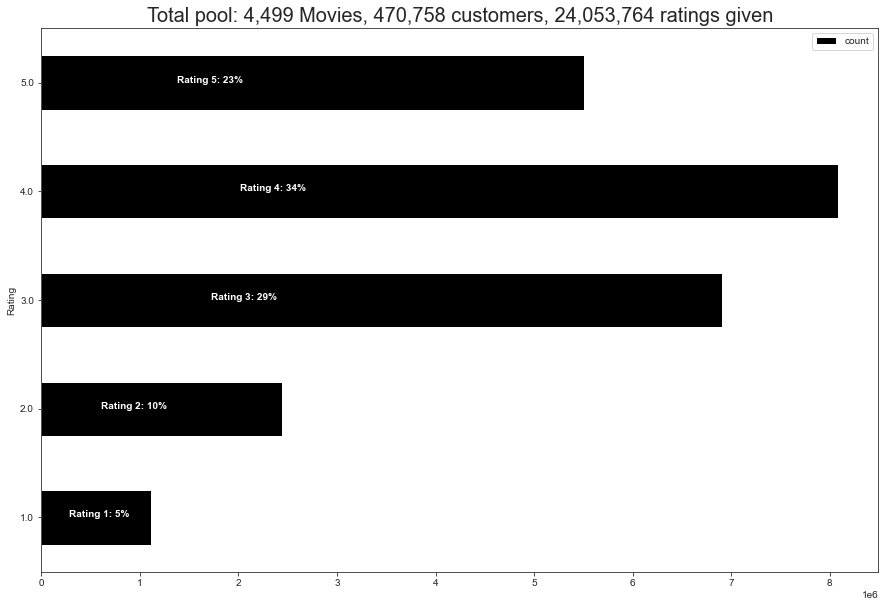

In [15]:
p = df.groupby('Rating')['Rating'].agg(['count'])

# get movie count
count_movie = df.isnull().sum()[1]

# get customer count
count_cust = df['Id_Cust'].nunique() - count_movie

# get rating count
rating_count = df['Id_Cust'].count() - count_movie

ax = p.plot(kind = 'barh', figsize = (15,10), color= 'black')
plt.title('Total pool: {:,} Movies, {:,} customers, {:,} ratings given'.format(count_movie, count_cust, rating_count), fontsize=20)
plt.axis('on')

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, 'Rating {}: {:.0f}%'.format(i, p.iloc[i-1][0]*100 / p.sum()[0]), color = 'white', weight = 'bold')



We then use the following code to include a column for Movie_Id

In [12]:
df_new = pd.DataFrame(pd.isnull(df.Rating))
df_new = df_new[df_new['Rating'] == True]
df_new = df_new.reset_index()

movie_np = []
movie_id = 1

for i,j in zip(df_new['index'][1:],df_new['index'][:-1]):
   
    temp = np.full((1,i-j-1), movie_id)
    movie_np = np.append(movie_np, temp)
    movie_id += 1


last_record = np.full((1,len(df) - df_new.iloc[-1, 0] - 1),movie_id)
movie_np = np.append(movie_np, last_record)

print('Movie numpy: {}'.format(movie_np))
print('Length: {}'.format(len(movie_np)))

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


Once we get a vector for the movie ID, we added it to the original dataframe to have users, with ratings, and the corresponding movie ID.

In [16]:

df = df[pd.notnull(df['Rating'])]

df['Movie_Id'] = movie_np.astype(int)
df['Id_Cust'] = df['Id_Cust'].astype(int)
print('-Dataset examples-')
print(df.iloc[::5000000, :])


-Dataset examples-
          Id_Cust  Rating  Movie_Id
1         1488844     3.0         1
5000996    501954     2.0       996
10001962   404654     5.0      1962
15002876   886608     2.0      2876
20003825  1193835     2.0      3825


Since we have a lot of data with either too few reviews or with customers that are not experienced reviewers, we decide to clean the data by using the quantile statistic, which in our case meant only taking through movies that have been reviewed over 3884 times and by customers that had at least reviewed 79 movies.

In [17]:
f = ['count','mean']

df_movie_summary = df.groupby('Movie_Id')['Rating'].agg(f)
df_movie_summary.index = df_movie_summary.index.map(int)
movie_benchmark = round(df_movie_summary['count'].quantile(0.8),0)
drop_movie_list = df_movie_summary[df_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

df_cust_summary = df.groupby('Id_Cust')['Rating'].agg(f)
df_cust_summary.index = df_cust_summary.index.map(int)
cust_benchmark = round(df_cust_summary['count'].quantile(0.8),0)
drop_cust_list = df_cust_summary[df_cust_summary['count'] < cust_benchmark].index

print('Customer minimum times of review: {}'.format(cust_benchmark))

Movie minimum times of review: 3884.0
Customer minimum times of review: 79.0


The final output can be seen in the following code, with around half of the observations not being taken into consideration.

In [18]:
print('Original Shape: {}'.format(df.shape))
df = df[~df['Movie_Id'].isin(drop_movie_list)]
df = df[~df['Id_Cust'].isin(drop_cust_list)]
print('After Trim Shape: {}'.format(df.shape))
print('-Data Examples-')
print(df.iloc[::5000000, :])

Original Shape: (24053764, 3)
After Trim Shape: (13528427, 3)
-Data Examples-
          Id_Cust  Rating  Movie_Id
5109       785314     1.0         8
8889698    332300     3.0      1770
17751978   629874     4.0      3391


For the sake of making the model run faster, we decided to make an additional trim, using the min movie rating of 10000 and min user ratigns of 200, instead of the previous cuts of 3884 and 79, respectively.

In [53]:
min_movie_ratings = 10000
filter_movies = (df['Movie_Id'].value_counts()>min_movie_ratings)
filter_movies = filter_movies[filter_movies].index.tolist()

# Filter sparse users
min_user_ratings = 200
filter_users = (df['Id_Cust'].value_counts()>min_user_ratings)
filter_users = filter_users[filter_users].index.tolist()

# Actual filtering
df_filterd = df[(df['Movie_Id'].isin(filter_movies)) & (df['Id_Cust'].isin(filter_users))]
del filter_movies, filter_users, min_movie_ratings, min_user_ratings
print('Shape User-Ratings unfiltered:\t{}'.format(df.shape))
print('Shape User-Ratings filtered:\t{}'.format(df_filterd.shape))


Shape User-Ratings unfiltered:	(13528427, 3)
Shape User-Ratings filtered:	(3173206, 3)


Now we match the movie titles csv to the dataset we've been cleaning. As the pandas library had a problem recognizing commas in the movie titles and the delimiters, we decided to skip the lines that were giving errors.  

In [69]:
df_title = pd.read_csv('movie_titles.csv', encoding = "ISO-8859-1",on_bad_lines='skip', header = None, names = ['Movie_Id', 'Year', 'Name'])
df_title.set_index('Movie_Id', inplace = True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


Now the fun begins... We decided to emphasize on a specific customer (user id 2649285) to create different models and predict the movies for that specific person, and getting the results compared by analyzing the performance in a test set.

First model: Singular Value Decomposition, also known as SVD. All of the models we got are from a library named "surprise", which provides lots of algorithms to deal with recommender systems. This is ideal for this project and use techniques related to eigenvalues and eigenvectors, as we saw in class with the PCAs.

In [59]:
reader = Reader()

svd = SVD()

user_2649285 = df_title.copy()
user_2649285 = user_2649285.reset_index()
user_2649285 = user_2649285[~user_2649285['Movie_Id'].isin(drop_movie_list)]


data = Dataset.load_from_df(df_filterd[['Id_Cust', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_2649285['Estimate_Score'] = user_2649285['Movie_Id'].apply(lambda x: svd.predict(2649285, x).est)

user_2649285 = user_2649285.drop('Movie_Id', axis = 1)

user_2649285 = user_2649285.sort_values('Estimate_Score', ascending=False)
print(user_2649285.head(10))

        Year                                               Name  \
2410  2001.0      Lord of the Rings: The Fellowship of the Ring   
267   2001.0                         Sex and the City: Season 4   
1469  2001.0                                    Alias: Season 1   
2753  1995.0                                Pride and Prejudice   
1870  2003.0  Pirates of the Caribbean: The Curse of the Bla...   
2888  1999.0                                  Friends: Season 6   
4386  2003.0                                      Love Actually   
2884  1994.0                      The Best of Friends: Season 1   
2859  2004.0                                  Finding Neverland   
3022  1994.0                      The Best of Friends: Season 2   

      Estimate_Score  
2410        4.473726  
267         4.461935  
1469        4.335774  
2753        4.305000  
1870        4.294538  
2888        4.231248  
4386        4.187907  
2884        4.187151  
2859        4.152527  
3022        4.147103  


The second model is known as BaselineOnly. 

In [63]:
from surprise import BaselineOnly
baselineonly = BaselineOnly()

user_2649285 = df_title.copy()
user_2649285 = user_2649285.reset_index()
user_2649285 = user_2649285[~user_2649285['Movie_Id'].isin(drop_movie_list)]


data = Dataset.load_from_df(df_filterd[['Id_Cust', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
baselineonly.fit(trainset)

user_2649285['Estimate_Score'] = user_2649285['Movie_Id'].apply(lambda x: baselineonly.predict(2649285, x).est)

user_2649285 = user_2649285.drop('Movie_Id', axis = 1)

user_2649285 = user_2649285.sort_values('Estimate_Score', ascending=False)
print(user_2649285.head(10))

Estimating biases using als...
        Year                                           Name  Estimate_Score
2410  2001.0  Lord of the Rings: The Fellowship of the Ring        4.099632
2136  1991.0                         The Simpsons: Season 3        4.063077
3889  2003.0                      Finding Nemo (Widescreen)        4.028169
4225  1999.0                                The Sixth Sense        4.018254
2810  1991.0                       The Silence of the Lambs        4.007093
2990  1990.0              The Simpsons: Treehouse of Horror        4.006085
2126  2000.0                                  CSI: Season 1        3.980627
2733  1995.0                                     Braveheart        3.946060
3793  2005.0                                  Batman Begins        3.936991
999   1989.0                         The Simpsons: Season 1        3.926812


In [65]:
from surprise import CoClustering

coclustering = CoClustering()

user_2649285 = df_title.copy()
user_2649285 = user_2649285.reset_index()
user_2649285 = user_2649285[~user_2649285['Movie_Id'].isin(drop_movie_list)]


data = Dataset.load_from_df(df_filterd[['Id_Cust', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
coclustering.fit(trainset)

user_2649285['Estimate_Score'] = user_2649285['Movie_Id'].apply(lambda x: coclustering.predict(2649285, x).est)

user_2649285 = user_2649285.drop('Movie_Id', axis = 1)

user_2649285 = user_2649285.sort_values('Estimate_Score', ascending=False)
print(user_2649285.head(10))

C:\Users\poche\AppData\Local\Temp\ipykernel_5584\1990172207.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coclustering.fit(trainset)


        Year                                           Name  Estimate_Score
2888  1999.0                              Friends: Season 6        4.102600
2884  1994.0                  The Best of Friends: Season 1        4.041244
3022  1994.0                  The Best of Friends: Season 2        4.009888
3865  2004.0                                        Shrek 2        3.969295
2410  2001.0  Lord of the Rings: The Fellowship of the Ring        3.964940
3889  2003.0                      Finding Nemo (Widescreen)        3.903914
4225  1999.0                                The Sixth Sense        3.884668
2810  1991.0                       The Silence of the Lambs        3.870652
2126  2000.0                                  CSI: Season 1        3.861544
3178  2001.0              The Princess Diaries (Fullscreen)        3.855051


In [67]:
from surprise import NMF

nmf = NMF()

user_2649285 = df_title.copy()
user_2649285 = user_2649285.reset_index()
user_2649285 = user_2649285[~user_2649285['Movie_Id'].isin(drop_movie_list)]


data = Dataset.load_from_df(df_filterd[['Id_Cust', 'Movie_Id', 'Rating']], reader)

trainset = data.build_full_trainset()
nmf.fit(trainset)

user_2649285['Estimate_Score'] = user_2649285['Movie_Id'].apply(lambda x: nmf.predict(2649285, x).est)

user_2649285 = user_2649285.drop('Movie_Id', axis = 1)

user_2649285 = user_2649285.sort_values('Estimate_Score', ascending=False)
print(user_2649285.head(10))

        Year                                           Name  Estimate_Score
3889  2003.0                      Finding Nemo (Widescreen)        3.960433
4225  1999.0                                The Sixth Sense        3.943841
2136  1991.0                         The Simpsons: Season 3        3.928155
2126  2000.0                                  CSI: Season 1        3.903950
2410  2001.0  Lord of the Rings: The Fellowship of the Ring        3.889923
3023  1994.0                 The Lion King: Special Edition        3.861339
2810  1991.0                       The Silence of the Lambs        3.838940
2733  1995.0                                     Braveheart        3.803991
1469  2001.0                                Alias: Season 1        3.789541
1597  1986.0                    Aliens: Collector's Edition        3.762760
